### Напоминаю, что лучше вместо этого ноутбука почитать курс mlcourse.ai

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from collections import  defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

In [2]:
train = pd.read_csv("../data/titanic/train.csv")
test = pd.read_csv("../data/titanic/test.csv")

И так мы зачитали данные. Теперь надо подумать, что с ними делать, как их делить. Зачем это делать?

Мы пытаемся сделать модель, которая будет максимально хорошо работать на всей генеральной совокупности, при этом мы видим лишь выборку (training set). Иными словами, модель должна обощаться и хорошо работать на новых данных. Допустим, мы создали на имеющихся данных некоторую модель. Как понять насколько она хороша? Насколько можно ей доверять? И не лучше ли взять другую модель?







Два наиболее популярных способа:
 * **отложенная выборка** (held-out/hold-out set). При таком подходе мы оставляем какую-то долю обучающей выборки (как правило от 20% до 40%), обучаем модель на остальных данных (60-80% исходной выборки) и считаем некоторую метрику качества модели (например, самое простое – долю правильных ответов в задаче классификации) на отложенной выборке.
 <img src="../images/1_obKmc_bTKbUFgcgryhaAnA.png">
 
 * **кросс-валидация** (cross-validation, на русский еще переводят как скользящий или перекрестный контроль). Тут самый частый случай – K-fold кросс-валидация
  <img src="../images/b1d706e6c9df49c297b6152878a2d03f.png">

Тут модель обучается $K$ раз на разных $(K - 1)$ подвыборках исходной выборки (белый цвет), а проверяется на одной подвыборке (каждый раз на разной, оранжевый цвет).
Получаются  $K$ оценок качества модели, которые обычно усредняются, выдавая среднюю оценку качества классификации/регрессии на кросс-валидации.

Кросс-валидация дает лучшую по сравнению с отложенной выборкой оценку качества модели на новых данных. Но кросс-валидация вычислительно дорогостоящая, если данных много.

Кросс-валидация – очень важная техника в машинном обучении (применяемая также в статистике и эконометрике), с ее помощью выбираются гиперпараметры моделей, сравниваются модели между собой, оценивается полезность новых признаков в задаче и т.д.

Что ещё надо учитывать при выборе способора кросс-валидации:
* есть ли дисбалас в классах
* есть ли временной зависимости в данных (В самом деле, если в данных есть временная зависимость, то модель должна предсказывать будущее, зная прошлое. Но что произойдет в случае временной зависимости, если использвать кросс-валидацию "в лоб"? Модель возьмет фолды из "прошлого", фолды из "будущего" и начнет предсказывать промежуточной этап. Как правильно это приведет к необосновому завышению качества, т.к. тренды будут взять из фолдов "будущего")
* сколько у вас данных

In [3]:
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
805,806,0,3,"Johansson, Mr. Karl Johan",male,31.0,0,0,347063,7.7750,NaN,S
390,391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,S
694,695,0,1,"Weir, Col. John",male,60.0,0,0,113800,26.5500,NaN,S
64,65,0,1,"Stewart, Mr. Albert A",male,NaN,0,0,PC 17605,27.7208,NaN,C
456,457,0,1,"Millet, Mr. Francis Davis",male,65.0,0,0,13509,26.5500,E38,S


Описание данных:
* **PassengerId** - номер пассажира. Какой-либо предсказательной силы не имеет
* **Survived** - целевая переменная, которую надо предсказать
* **Pclass** - класс обслуживания
* **Name** - имя пассажира
* **Sex** - пол
* **Age** - возраст
* **SibSp** - сколько братьев\cестер\супруга на рейсе
* **Parch** - сколько детей\родители на рейсе
* **Ticket** - номер билета
* **Fare** - стоимость билета (?)
* **Cabin** - каюта
* **Embarked** - порт посадки

### Определимся с признакми, которые надо убрать

In [4]:
to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']

In [5]:
y = train['Survived'].values
train.drop('Survived', inplace=True, axis=1)

X = train.drop(to_drop, axis=1)
test.drop(to_drop, axis=1, inplace=True)

In [6]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [7]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


### Типы прзнаков
Разобьем признаки на числовые (numeric features) и категориальные признаки (categorical features). Холивар: (Pclass можно отнести туда, и туда)

Зачем это нужно? 
Каждый тип признаков требуется свою предобратку. Это нужно для увелчения качества модели. Начиная от банальной работоспобсноти (в большинство модей нельзя засунуть текстовые фичи), заканчивая повышением качества модели.

In [8]:
num_feat = ['Age', 'SibSp', 'Parch', 'Fare']
cat_feat = ['Pclass', 'Sex', 'Embarked']

### Категориальные признаки

In [9]:
X[cat_feat].head()

,Pclass,Sex,Embarked
0,3,male,S
1,1,female,C
2,3,female,S
3,1,female,S
4,3,male,S


In [10]:
label_encoders = defaultdict(LabelEncoder)

X[cat_feat] = X[cat_feat].fillna('no_data')

X_labeled = X[cat_feat].apply(lambda x: label_encoders[x.name].fit_transform(x))
X_labeled.head()

,Pclass,Sex,Embarked
0,2,1,2
1,0,0,0
2,2,0,2
3,0,0,2
4,2,1,2


In [11]:
ohe = OneHotEncoder(sparse=False)

X_encded = ohe.fit_transform(X_labeled)
X_encded

array([[0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.]])

### Числовые

In [12]:
X[num_feat].head()

,Age,SibSp,Parch,Fare
0,22.0,1,0,7.2500
1,38.0,1,0,71.2833
2,26.0,0,0,7.9250
3,35.0,1,0,53.1000
4,35.0,0,0,8.0500


In [13]:
X[num_feat] = X[num_feat].fillna(X[num_feat].mean())

In [14]:
scaller = StandardScaler()

X_scalled = scaller.fit_transform(X[num_feat])
X_scalled

array([[-0.5924806 ,  0.43279337, -0.47367361, -0.50244517],
       [ 0.63878901,  0.43279337, -0.47367361,  0.78684529],
       [-0.2846632 , -0.4745452 , -0.47367361, -0.48885426],
       ...,
       [ 0.        ,  0.43279337,  2.00893337, -0.17626324],
       [-0.2846632 , -0.4745452 , -0.47367361, -0.04438104],
       [ 0.17706291, -0.4745452 , -0.47367361, -0.49237783]])

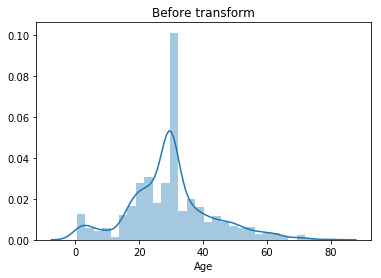

In [15]:
sns.distplot(X['Age']).set_title("Before transform");

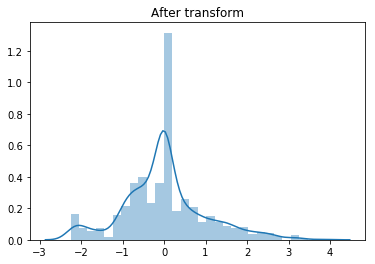

In [16]:
sns.distplot(X_scalled[:, 0]).set_title("After transform");

### Соберем вместе

In [17]:
X_procesed = np.hstack((X_encded, X_scalled))
X_procesed.shape

(891, 13)

### Простая модель

In [18]:
logit = LogisticRegression()

cross_val_score(logit, X_procesed, y, n_jobs=-1)

array([0.7979798 , 0.78451178, 0.79461279])

In [19]:
knn = KNeighborsClassifier(n_neighbors=4)

cross_val_score(knn, X_procesed, y, n_jobs=-1)

array([0.77777778, 0.8047138 , 0.79461279])